# Convolutional Neural Networks

In this tutorial we continue our journey in deep learning by looking at convolutional neural networks or ConvNets.

Run the notebook in Google colab:
https://colab.research.google.com/github/heprom/cvml/blob/main/corrections/CNN_cor.ipynb

You should use GPU acceleration to train your network, on google colab, before starting working, go to Execution -> Modifier le Type d'Execution -> select GPU as hardware accelerator

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt, cm

## Understanding convolutions

In thisfirst section, we experiment convolutions on images using simple `numpy` operations. We first work with a single channel image from MNIST and then a 3 channel RGB image of a cat.

In [4]:
from sklearn.datasets import load_digits
mnist = load_digits()

create a variable `image` to hold the first $8\times8$ image in the data set

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


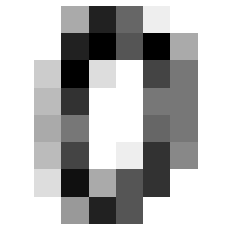

In [5]:
image = mnist['images'][0]
print(image)
plt.imshow(image, cmap=cm.gray_r)
plt.axis('off')
plt.show()

create the following $3\times 3$ kernel as a numpy array: $\left[\begin{array}{ccc}-1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1\end{array}\right]$

In [6]:
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
print(kernel)

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


pad the image with zeros.

In [7]:
kernel_size = kernel.shape[0]
pad = (kernel_size - 1) // 2
im = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
print('paded image size is now {}'.format(im.shape))

paded image size is now (10, 10)


convolve the kernel with the image. Create an algorithm using for loops to output the convolution to a new variable `conv`.

output size of the convolution is (8, 8)


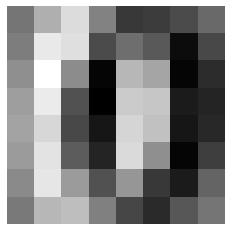

In [8]:
conv = np.empty_like(image)

for i in range(pad, im.shape[0] - pad):
    for j in range(pad, im.shape[1] - pad):
        subset = im[i-pad:i+pad+1, j-pad:j+pad+1]
        conv[i-pad, j-pad] = np.dot(kernel.ravel(), subset.ravel())  # element-wise multiplication

print('output size of the convolution is {}'.format(conv.shape))
plt.imshow(conv, cmap=cm.gray)
plt.axis('off')
plt.show()

now this works, make a function called `convolve` which takes for input an image, a kernel and output the result of the convolution. Assume image is in form (n x m x channels) and represented by floats in the [0, 1] range.

In [9]:
def convolve(image, kernel):
    kernel_size = kernel.shape[0]
    pad = (kernel_size - 1) // 2
    im = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
    conv = np.empty_like(image)

    for i in range(pad, im.shape[0] - pad):
        for j in range(pad, im.shape[1] - pad):
            # get the (i, j) subset of size (2 x pad + 1)
            subset = im[i - pad:i + pad + 1, j - pad:j + pad + 1]
            # perform the convolution
            conv[i - pad, j - pad] = (subset * kernel).sum()
    conv = (conv - conv.min()) / (conv.max() - conv.min())  # normalization
    return conv

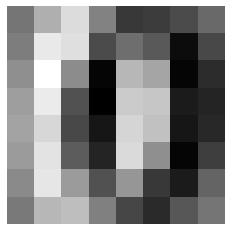

In [12]:
plt.imshow(convolve(image, kernel), cmap=cm.gray)
plt.axis('off')
plt.show()

Now let's work with a 3 channel RGB image. Load it, convert if to float representation and in gray scale mode.

In [13]:
from skimage import data
cat = data.chelsea().astype(np.float)
cat = np.mean(cat, axis=2)  # convert to gray scale
cat /= cat.max()  # with float representation, the range is [0, 1]
print(cat.shape)
print(cat.dtype)
print(cat.max())

(300, 451)
float64
1.0


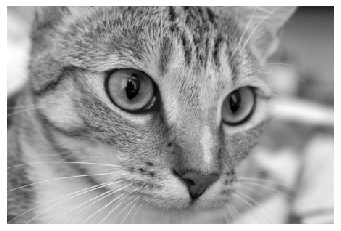

In [14]:
plt.imshow(cat, cmap=cm.gray)
plt.axis('off')
plt.show()

create all the following kernel and try them out:

 - Blur kernel: $\left[\begin{array}{ccc}1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1\end{array}\right]$
 - Laplacian kernel: $\left[\begin{array}{ccc}0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0\end{array}\right]$
 - Emboss kernel: $\left[\begin{array}{ccc}-2 & -1 & 0 \\ -1 & 1 & 1 \\ 0 & 1 & 2\end{array}\right]$

In [15]:
# blur filters
blur3 = np.array(([1, 1, 1], [1, 1, 1], [1, 1, 1]))
blur5 = np.ones((5, 5))
blur7 = np.ones((7, 7))

# sharpen
sharpen = np.array(([0, -1, 0], [-1, 5, -1], [0, -1, 0]))

# Laplacian kernel
laplacian = np.array(([0, 1, 0], [1, -4, 1], [0, 1, 0]))

# construct the Sobel x-axis kernel
sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))

# construct the Sobel y-axis kernel
sobelY = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))

# construct an emboss kernel
emboss = np.array(([-2, -1, 0], [-1, 1, 1], [0, 1, 2]))

kernels = [blur3, sharpen, laplacian, emboss]
kernel_labels = ['blur3', 'sharpen', 'laplacian', 'emboss']

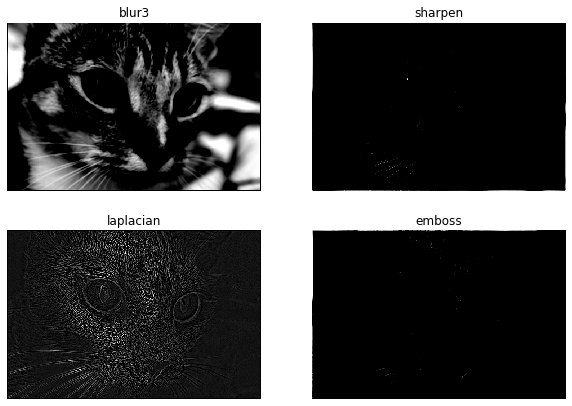

In [16]:
fig = plt.figure(figsize=(10, 7))
for i in range(len(kernels)):
    ax = plt.subplot(2, 2, i + 1)
    convolution = convolve(cat, kernels[i])
    plt.imshow(convolution, cmap=cm.gray, vmin=0.6, vmax=0.9)
    plt.title(kernel_labels[i])
    plt.axis('off')
plt.show()

### Automated classification of material microstructure

In [188]:
# grab indices of labeled images
data_dir = '/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs'
data_dir = '/home/proudhon/students/test/'
labels = ['A', 'B', 'C']
indices_A = [int(image_name.split('micrograph')[1].split('.')[0]) for image_name in os.listdir(os.path.join(data_dir, 'A'))]
indices_B = [int(image_name.split('micrograph')[1].split('.')[0]) for image_name in os.listdir(os.path.join(data_dir, 'B'))]
indices_C = [int(image_name.split('micrograph')[1].split('.')[0]) for image_name in os.listdir(os.path.join(data_dir, 'C'))]

In [186]:
# convert tif images as jpg -> could be used to make a tar.gz file and import automaticaly with tensorflow
from PIL import Image

data_dir = '/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs'
save_dir = '/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/C/'
for index in indices_C:
    try:
        image_path = os.path.join(data_dir, 'micrograph%d.tif' % index)
        print(image_path)   
        image = TiffFile(image_path).asarray()[:484, :]
        save_path = os.path.join(save_dir, 'micrograph%d.jpg' % index)
        img = Image.fromarray(image)
        img.save(save_path)
        #plt.imsave(save_path, image)
    except ValueError:
        print('image %s is invalid' % image_name)
        


/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph70.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph112.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph14.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph113.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph89.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph72.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph24.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph47.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph33.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph897.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs/micrograph968.tif
/home/proudhon/teaching/DMS/CVML/cvml/future/corre

In [197]:
from tifffile import TiffFile
import numpy as np
import os

size = 64
input_shape = (484, 645)
ds = 2
nx, ny = (np.array(input_shape) / (ds * size)).astype(int)
#nx, ny = 3, 3

all_indices = indices_A + indices_B + indices_C
all_indices.sort()
print(len(all_indices), 'images in total')

data_dir = '/home/proudhon/teaching/DMS/CVML/cvml/future/corrections/micrographs'
X = np.empty((len(nx * ny * all_indices), size, size), dtype=float)
y = np.empty(len(nx * ny * all_indices), dtype=np.uint8)
i = 0
for index in all_indices:
    try:
        image_path = os.path.join(data_dir, 'micrograph%d.tif' % index)
        #print(image_path)   
        image = TiffFile(image_path).asarray()
        for j in range(nx):
            start_col = int(j * ds * size)
            for k in range(ny):
                start_row = int(k * ds * size)
                roi = image[start_col:start_col + ds * size:ds, start_row:start_row + ds * size:ds]
                if (roi.max() - roi.min()) < 1e-3:
                    print(roi.max(), roi.min(), index)
                X[i] = (roi - roi.min()) / (roi.max() - roi.min())
                if index in indices_A:
                    y[i] = 0
                elif index in indices_B:
                    y[i] = 1
                else:
                    y[i] = 2
                i = i + 1
    except ValueError:
        print('image %s is invalid' % image_name)

X = np.expand_dims(X, axis=3)
print('created %d images' % X.shape[0])
labels = ['A', 'B', 'C']
data = {'X' : X, 'y' : y, 'labels' : labels}
np.save('micrographs.npy', data)


192 images in total
created 2880 images


In [190]:
np.unique(y)

array([0, 1, 2], dtype=uint8)

In [198]:
np.savez('micrographs_%d.npz' % size, X=X, y=y)

In [199]:
pwd

'/home/hproudhon/teaching/DMS/CVML/cvml/future/corrections'

In [194]:
data['X'].shape

(2880, 64, 64, 1)

In [195]:
data['X'].max()

1.0

In [196]:
data['X'][0].shape

(64, 64, 1)

## Our First ConvNet: ShallowNet architecture

This model only contains a few layers, so it is perfect to get started with CNN. The architecture can be summarized as:

```INPUT => CONV => RELU => FC```

### As usual start by loading our data set

Here we will work with microstructure images with 3 classes: A, B and C.

In [171]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

with np.load('micrographs_64.npz') as data:
  X = data['X']
  y = data['y']
  labels = data['labels']

# observe that each image is 3D with one channel (gray level images)
print('data set contains %d images of size %d x %d x %d' % (X.shape[0], X.shape[1], X.shape[2], X.shape[3]))

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 32

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

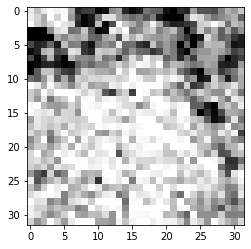

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

Partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing


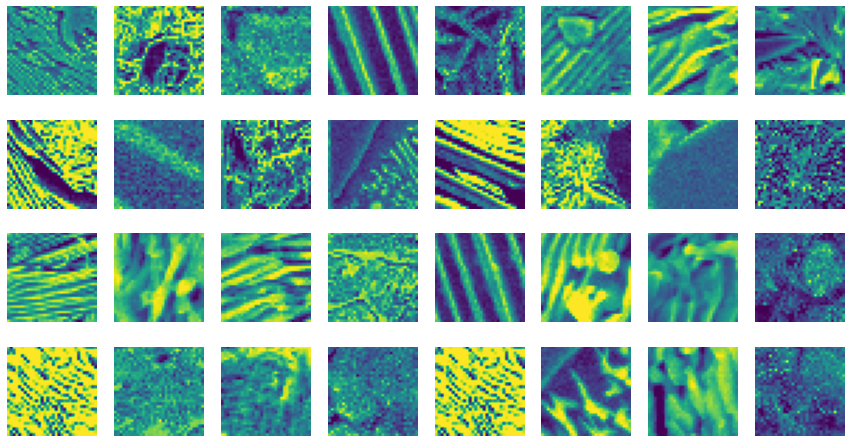

In [105]:
# display micrographs from a given class
class_A = X_train[np.where(y_train == 0)]
class_B = X_train[np.where(y_train == 1)]
class_C = X_train[np.where(y_train == 2)]
class_A.shape

N = 8
M = 4
indices = np.random.randint(0, class_B.shape[0], size=N*M)

plt.figure(figsize=(15, 8))
for i in range(N * M):
    ax = plt.subplot(M, N, i + 1)
    plt.imshow(class_B[indices[i]])
    plt.axis('off')
plt.show()

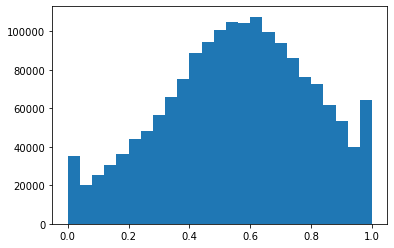

In [133]:
# check histograms
plt.hist(class_C.flatten(), bins=25)
plt.show()

build our simple CNN model

### Build the model with Keras

start importing useful stuff from Keras

In [138]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  layers.Conv2D(16, 3, padding='same', input_shape=(64, 64, 1), activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

AttributeError: module 'tensorflow.keras.layers' has no attribute 'RandomFlip'

Save our model to the disk (to reuse it later), this is called **serialization**. In Keras, the architecture of the model and the trained weights are save to a HDF5 file.

In [30]:
model.save('microstructure_cnn.h5')

Now evaluate the network

In [64]:
predictions = model.predict(X_train, batch_size=32)

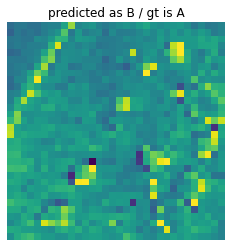

In [120]:
# on train data
index = 5
plt.imshow(X_train[index])
plt.title('predicted as %c / gt is %c' % (labels[predictions[index].argmax()], labels[y_train[index].argmax()]))
plt.axis('off')
plt.show()

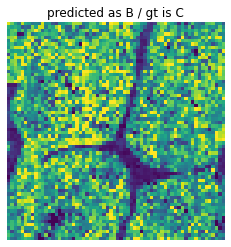

In [76]:
# on test data
index = 5
plt.imshow(X_test[index])
plt.title('predicted as %c / gt is %c' % (labels[predictions[index].argmax()], labels[y_test[index].argmax()]))
plt.axis('off')
plt.show()

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

              precision    recall  f1-score   support

        cats       0.53      0.87      0.66       249
        dogs       0.76      0.27      0.40       262
       panda       0.83      0.86      0.84       239

    accuracy                           0.66       750
   macro avg       0.71      0.67      0.63       750
weighted avg       0.71      0.66      0.63       750



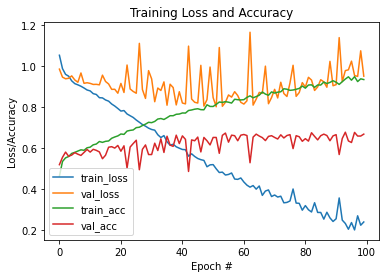

In [126]:
# plot the training loss and accuracy
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

## A Deeper ConvNet for CIFAR-10

Finally for this tutorial we try this a deeper CNN with the rather difficult CIFAR-10 data set. We will see that we can reach > 80% accuracy which is much better that previous attempts we did.

As a side note, with much deeper networks (outside the scope of this tutorial since they need GPu hardware to train), it is *relatively easy* to acheive >90% (and even 95%) precision on this data set.

In [45]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float') / 255.0
X_test = X_test.astype('float') / 255.0
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'truck']

In [46]:
print(X_train[0].shape)

(32, 32, 3)


convert the labels from integers to vectors

In [47]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

Import all the bells and whistles we need from from Keras

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

Initialize the optimizer and model, the first series of CONF has 32 filters, the second 64. The kernel sizes are (3, 3).

In [72]:
model = Sequential()

# first CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X[0].shape))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier for the 10 classes
model.add(Dense(3))
model.add(Activation('softmax'))


Compile our model with SGD + Momentum, crossentropy loss and use accuracy as our metric. use a learning rate of 0.01 and learning rate decay (40 epochs). Use the usual value for momentum and activate nesterov acceleration.

In [73]:
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"])

Train the network using 40 epochs and a mini batch size of 64.

In [74]:
H = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    batch_size=64, 
    epochs=10,  # should go to 40 
    verbose=1)

Epoch 1/10
16/16 [==============================] - 4s 234ms/step - loss: 1.7243 - accuracy: 0.4543 - val_loss: 1.2234 - val_accuracy: 0.3294
Epoch 2/10
16/16 [==============================] - 4s 231ms/step - loss: 0.9109 - accuracy: 0.6148 - val_loss: 1.7313 - val_accuracy: 0.3294
Epoch 3/10
16/16 [==============================] - 4s 238ms/step - loss: 0.5901 - accuracy: 0.7778 - val_loss: 2.3279 - val_accuracy: 0.3294
Epoch 4/10
16/16 [==============================] - 4s 241ms/step - loss: 0.5029 - accuracy: 0.7943 - val_loss: 2.5992 - val_accuracy: 0.3294
Epoch 5/10
16/16 [==============================] - 4s 241ms/step - loss: 0.4565 - accuracy: 0.8322 - val_loss: 2.9725 - val_accuracy: 0.3294
Epoch 6/10
16/16 [==============================] - 4s 233ms/step - loss: 0.3077 - accuracy: 0.8672 - val_loss: 3.5599 - val_accuracy: 0.3294
Epoch 7/10
16/16 [==============================] - 4s 234ms/step - loss: 0.2717 - accuracy: 0.9074 - val_loss: 2.4765 - val_accuracy: 0.3492
Epoch 

Save our trained model to the disk.

In [59]:
model.save('miniVGGnet_micrographs.h5')

Now evaluate the model.

In [56]:
predictions = model.predict(X_test, batch_size=64)

In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

              precision    recall  f1-score   support

       plane       0.83      0.75      0.79      1000
         car       0.91      0.87      0.89      1000
        bird       0.76      0.64      0.69      1000
         cat       0.61      0.63      0.62      1000
        deer       0.77      0.73      0.75      1000
         dog       0.65      0.71      0.68      1000
        frog       0.79      0.89      0.84      1000
       horse       0.85      0.81      0.83      1000
        boat       0.83      0.92      0.87      1000
       truck       0.86      0.89      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



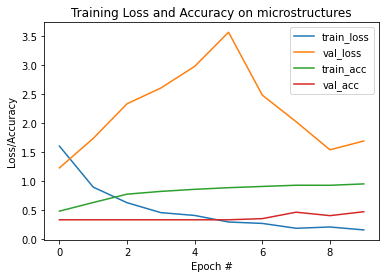

In [75]:
# plot the training loss and accuracy
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy on microstructures')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

Finally label a few images with their prediction

In [83]:
N = 8
M = 4
indices = np.random.randint(0, y_test.shape[0], size=N*M)

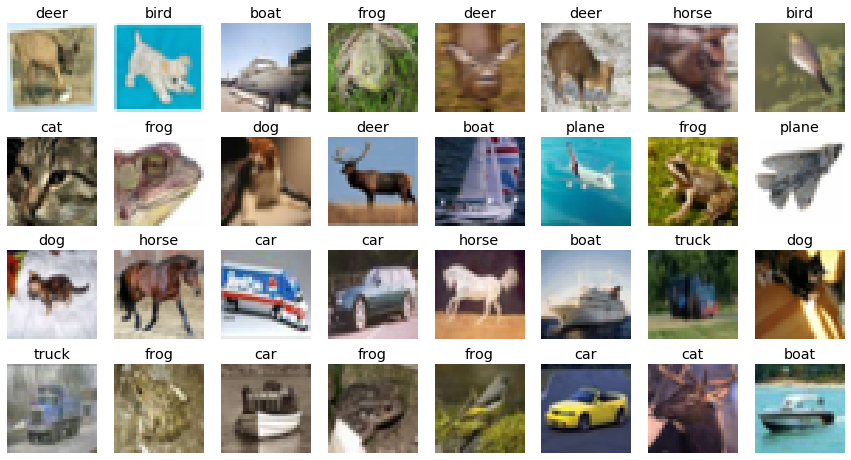

In [84]:
plt.figure(figsize=(15, 8))
for i in range(N * M):
    ax = plt.subplot(M, N, i + 1)
    plt.imshow(X_test[indices[i]])
    plt.axis('off')
    plt.title('%s' % labels[predictions[indices[i]].argmax()])
plt.show()